## **Model Tuning Notebook**

In [1]:
from numba import cuda
import tensorflow as tf

def clear_gpu_memory():
    device = cuda.get_current_device()
    device.reset() # dump the memory contents to free up the memory (it accumulates over the session)
    
# CUDA (Nvidia GPU Computing)
if len(tf.config.list_physical_devices('GPU')) > 0:
    gpus = tf.config.list_physical_devices('GPU')
    print("Num GPUs Available: ", len(gpus))
    
    clear_gpu_memory()
    
    tf.config.experimental.set_memory_growth(gpus[0], True)

    tf.config.set_logical_device_configuration(
    gpus[0], 
    [tf.config.LogicalDeviceConfiguration(memory_limit=8192)])  # limit to 4GB

    tf.compat.v1.disable_eager_execution()


Num GPUs Available:  1


In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append('../')

from src.utils.modeling import *
from src.utils.preproc import *

from keras.models import Model, Sequential, load_model
from keras.applications import VGG16
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam

from sklearn.metrics import classification_report

In [3]:
# because the utils in the src are designed to be run from the root of the project,
# and by default jupyter runs from the notebook directory we need to change the working directory to the root

def find_project_root(filename=".git"): # .git is located in the root of the project
    current_dir = os.getcwd()
    while current_dir != os.path.dirname(current_dir): # stops only when at the root (moves up 1 level each iteration)
        if filename in os.listdir(current_dir):
            return current_dir
        current_dir = os.path.dirname(current_dir)

project_root = find_project_root()
os.chdir(project_root)  # change the working directory to the project root

print("Project root:", project_root, "CWD:", os.getcwd())

Project root: d:\deep_learning_project CWD: d:\deep_learning_project


### **Binary Classification Models Fine-Tuning**

#### **Traditional**

#### **Pre-Trained**

**VGG 16**

In [4]:
def binary_classification_vgg16_model(input_shape):
    
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # train some layers and freeze others
    for layer in base_model.layers[:-7]:
        layer.trainable = False
    for layer in base_model.layers[-7:]:
        layer.trainable = True

    model = Sequential()
    
    model.add(base_model)
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(1, activation='sigmoid'))
    
    # low learning rate for fine tuning
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [5]:
if len(tf.config.list_physical_devices('GPU')) > 0:
    clear_gpu_memory()

train_gen, val_gen, test_gen, class_weights = preproc_pipeline(image_resolution=(224, 224),  
                                                    classification_type='binary',
                                                    use_data_augmentation=True,
                                                    augmented_images_per_image=6,
                                                    batch_size=64)

vgg16_binary = binary_classification_vgg16_model((224, 224, 3))

fitted_vgg16_binary = train_model(train_gen, val_gen, vgg16_binary, class_weights=class_weights, epochs=30, early_stopping_patience=8)

Number of training images before data augmentation: 5533
Number of training images after data augmentation: 38731
Epoch 1/30
606/606 [==============================] - ETA: 0s - batch: 302.5000 - size: 63.9125 - loss: 0.6968 - accuracy: 0.4464

c:\Users\vic\miniconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


606/606 [==============================] - 734s 1s/step - batch: 302.5000 - size: 63.9125 - loss: 0.6968 - accuracy: 0.4464 - val_loss: 0.6935 - val_accuracy: 0.3137
Epoch 2/30
606/606 [==============================] - 614s 1s/step - batch: 302.5000 - size: 63.9125 - loss: 0.6932 - accuracy: 0.4255 - val_loss: 0.6934 - val_accuracy: 0.3137
Epoch 3/30
606/606 [==============================] - 613s 1s/step - batch: 302.5000 - size: 63.9125 - loss: 0.6930 - accuracy: 0.3849 - val_loss: 0.6932 - val_accuracy: 0.3137
Epoch 4/30
606/606 [==============================] - 613s 1s/step - batch: 302.5000 - size: 63.9125 - loss: 0.6933 - accuracy: 0.5582 - val_loss: 0.6932 - val_accuracy: 0.3137
Epoch 5/30
192/606 [========>.....................] - ETA: 6:52 - batch: 95.5000 - size: 64.0000 - loss: 0.6937 - accuracy: 0.3838

KeyboardInterrupt: 

<i> Data augmentation clearly improves the model's performance. </i>

In [4]:
model = load_model('src/models/vgg16_binary_classification_V1.h5')

Loading test data...
Starting model evaluation...
Total number of samples in the test generator: 300


d:\deep_learning_project\notebooks\..\src\utils\modeling.py:80: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_prob = model.predict_generator(test_gen, steps=(total_samples // test_gen.batch_size) + 1) # +1 to account for remaining samples that don't make a full batch
c:\Users\vic\miniconda3\envs\tf\lib\site-packages\keras\engine\training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,



Accuracy: 0.8133

Classification Report:
+-----------+-------------+----------+------------+-----------+
| Class     |   Precision |   Recall |   F1-Score |   Support |
+===========+=============+==========+============+===========+
| Benign    |    0.756757 | 0.595745 |   0.666667 |        94 |
+-----------+-------------+----------+------------+-----------+
| Malignant |    0.831858 | 0.912621 |   0.87037  |       206 |
+-----------+-------------+----------+------------+-----------+

Overall Metrics:
+------------------------+----------+
| Metric                 |    Value |
+========================+==========+
| Accuracy               | 0.813333 |
+------------------------+----------+
| Macro Avg Precision    | 0.794308 |
+------------------------+----------+
| Macro Avg Recall       | 0.754183 |
+------------------------+----------+
| Macro Avg F1-Score     | 0.768519 |
+------------------------+----------+
| Weighted Avg Precision | 0.808327 |
+------------------------+----------

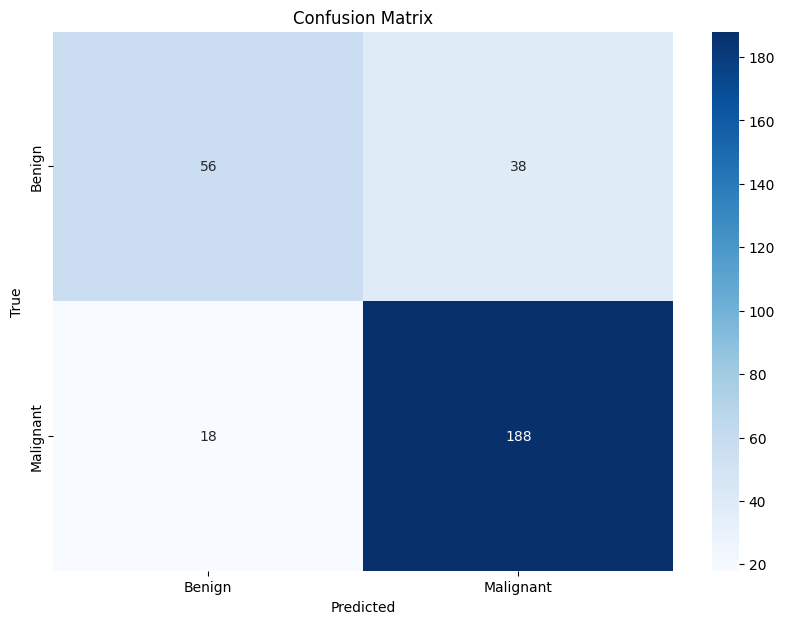

Plotted confusion matrix.
Evaluation complete. Returning results.


{'accuracy': 0.8133333333333334,
 'classification_report': {'Benign': {'precision': 0.7567567567567568,
   'recall': 0.5957446808510638,
   'f1-score': 0.6666666666666666,
   'support': 94.0},
  'Malignant': {'precision': 0.831858407079646,
   'recall': 0.912621359223301,
   'f1-score': 0.8703703703703703,
   'support': 206.0},
  'accuracy': 0.8133333333333334,
  'macro avg': {'precision': 0.7943075819182014,
   'recall': 0.7541830200371824,
   'f1-score': 0.7685185185185185,
   'support': 300.0},
  'weighted avg': {'precision': 0.8083265566451406,
   'recall': 0.8133333333333334,
   'f1-score': 0.8065432098765432,
   'support': 300.0}},
 'confusion_matrix': array([[ 56,  38],
        [ 18, 188]], dtype=int64)}

In [5]:
evaluate_model(model, classification_type='binary', desired_magnification='40X')

Loading test data...
Starting model evaluation...
Total number of samples in the test generator: 312


d:\deep_learning_project\notebooks\..\src\utils\modeling.py:80: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_prob = model.predict_generator(test_gen, steps=(total_samples // test_gen.batch_size) + 1) # +1 to account for remaining samples that don't make a full batch



Accuracy: 0.9006

Classification Report:
+-----------+-------------+----------+------------+-----------+
| Class     |   Precision |   Recall |   F1-Score |   Support |
+===========+=============+==========+============+===========+
| Benign    |    0.858696 | 0.814433 |   0.835979 |        97 |
+-----------+-------------+----------+------------+-----------+
| Malignant |    0.918182 | 0.939535 |   0.928736 |       215 |
+-----------+-------------+----------+------------+-----------+

Overall Metrics:
+------------------------+----------+
| Metric                 |    Value |
+========================+==========+
| Accuracy               | 0.900641 |
+------------------------+----------+
| Macro Avg Precision    | 0.888439 |
+------------------------+----------+
| Macro Avg Recall       | 0.876984 |
+------------------------+----------+
| Macro Avg F1-Score     | 0.882357 |
+------------------------+----------+
| Weighted Avg Precision | 0.899688 |
+------------------------+----------

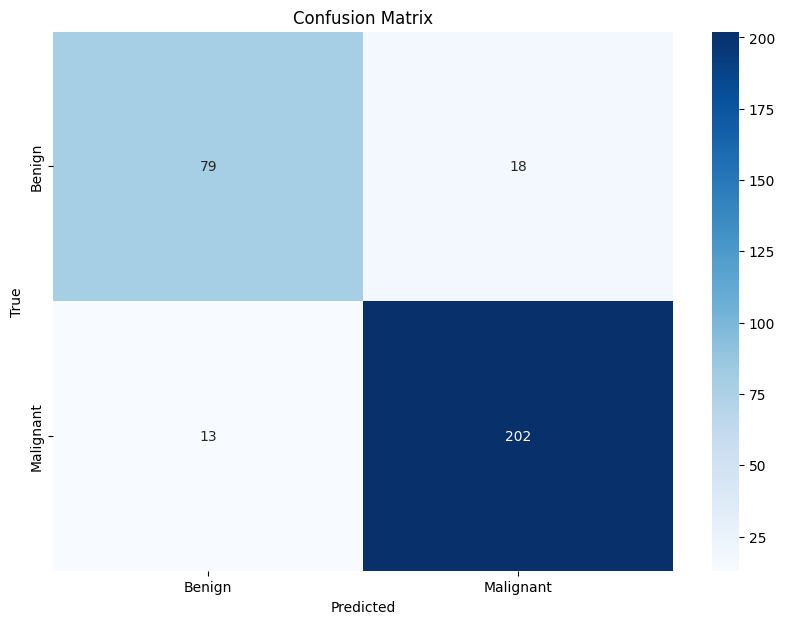

Plotted confusion matrix.
Evaluation complete. Returning results.


{'accuracy': 0.9006410256410257,
 'classification_report': {'Benign': {'precision': 0.8586956521739131,
   'recall': 0.8144329896907216,
   'f1-score': 0.8359788359788359,
   'support': 97.0},
  'Malignant': {'precision': 0.9181818181818182,
   'recall': 0.9395348837209302,
   'f1-score': 0.9287356321839081,
   'support': 215.0},
  'accuracy': 0.9006410256410257,
  'macro avg': {'precision': 0.8884387351778656,
   'recall': 0.8769839367058259,
   'f1-score': 0.882357234081372,
   'support': 312.0},
  'weighted avg': {'precision': 0.8996877216985913,
   'recall': 0.9006410256410257,
   'f1-score': 0.8998977820816901,
   'support': 312.0}},
 'confusion_matrix': array([[ 79,  18],
        [ 13, 202]], dtype=int64)}

In [9]:
evaluate_model(model, classification_type='binary', desired_magnification='100X')

Loading test data...
Starting model evaluation...
Total number of samples in the test generator: 302


d:\deep_learning_project\notebooks\..\src\utils\modeling.py:80: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_prob = model.predict_generator(test_gen, steps=(total_samples // test_gen.batch_size) + 1) # +1 to account for remaining samples that don't make a full batch



Accuracy: 0.9570

Classification Report:
+-----------+-------------+----------+------------+-----------+
| Class     |   Precision |   Recall |   F1-Score |   Support |
+===========+=============+==========+============+===========+
| Benign    |    0.907216 | 0.956522 |   0.931217 |        92 |
+-----------+-------------+----------+------------+-----------+
| Malignant |    0.980488 | 0.957143 |   0.968675 |       210 |
+-----------+-------------+----------+------------+-----------+

Overall Metrics:
+------------------------+----------+
| Metric                 |    Value |
+========================+==========+
| Accuracy               | 0.956954 |
+------------------------+----------+
| Macro Avg Precision    | 0.943852 |
+------------------------+----------+
| Macro Avg Recall       | 0.956832 |
+------------------------+----------+
| Macro Avg F1-Score     | 0.949946 |
+------------------------+----------+
| Weighted Avg Precision | 0.958167 |
+------------------------+----------

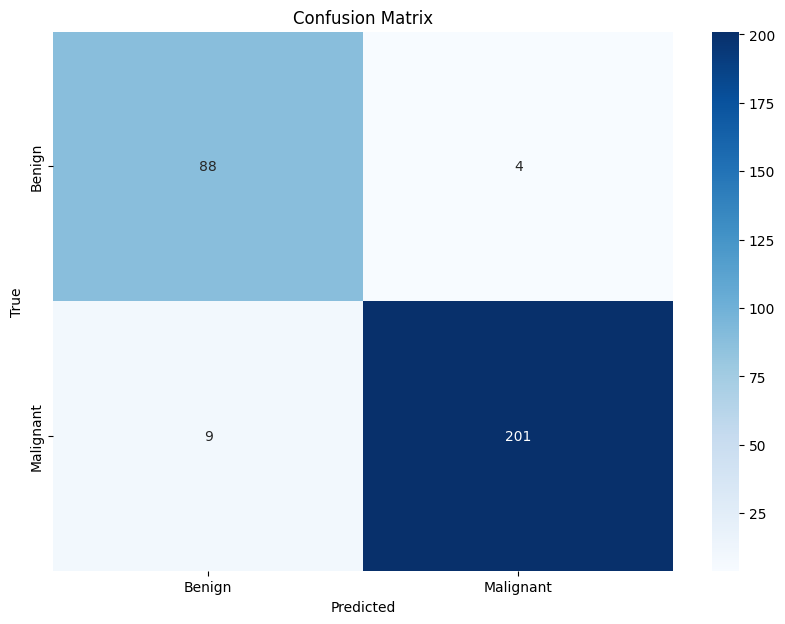

Plotted confusion matrix.
Evaluation complete. Returning results.


{'accuracy': 0.956953642384106,
 'classification_report': {'Benign': {'precision': 0.9072164948453608,
   'recall': 0.9565217391304348,
   'f1-score': 0.9312169312169312,
   'support': 92.0},
  'Malignant': {'precision': 0.9804878048780488,
   'recall': 0.9571428571428572,
   'f1-score': 0.9686746987951808,
   'support': 210.0},
  'accuracy': 0.956953642384106,
  'macro avg': {'precision': 0.9438521498617047,
   'recall': 0.9568322981366459,
   'f1-score': 0.949945815006056,
   'support': 302.0},
  'weighted avg': {'precision': 0.9581667435435877,
   'recall': 0.956953642384106,
   'f1-score': 0.9572637232415416,
   'support': 302.0}},
 'confusion_matrix': array([[ 88,   4],
        [  9, 201]], dtype=int64)}

In [10]:
evaluate_model(model, classification_type='binary', desired_magnification='200X')

Loading test data...
Starting model evaluation...
Total number of samples in the test generator: 273


d:\deep_learning_project\notebooks\..\src\utils\modeling.py:80: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred_prob = model.predict_generator(test_gen, steps=(total_samples // test_gen.batch_size) + 1) # +1 to account for remaining samples that don't make a full batch



Accuracy: 0.9194

Classification Report:
+-----------+-------------+----------+------------+-----------+
| Class     |   Precision |   Recall |   F1-Score |   Support |
+===========+=============+==========+============+===========+
| Benign    |    0.892857 | 0.852273 |   0.872093 |        88 |
+-----------+-------------+----------+------------+-----------+
| Malignant |    0.931217 | 0.951351 |   0.941176 |       185 |
+-----------+-------------+----------+------------+-----------+

Overall Metrics:
+------------------------+----------+
| Metric                 |    Value |
+========================+==========+
| Accuracy               | 0.919414 |
+------------------------+----------+
| Macro Avg Precision    | 0.912037 |
+------------------------+----------+
| Macro Avg Recall       | 0.901812 |
+------------------------+----------+
| Macro Avg F1-Score     | 0.906635 |
+------------------------+----------+
| Weighted Avg Precision | 0.918852 |
+------------------------+----------

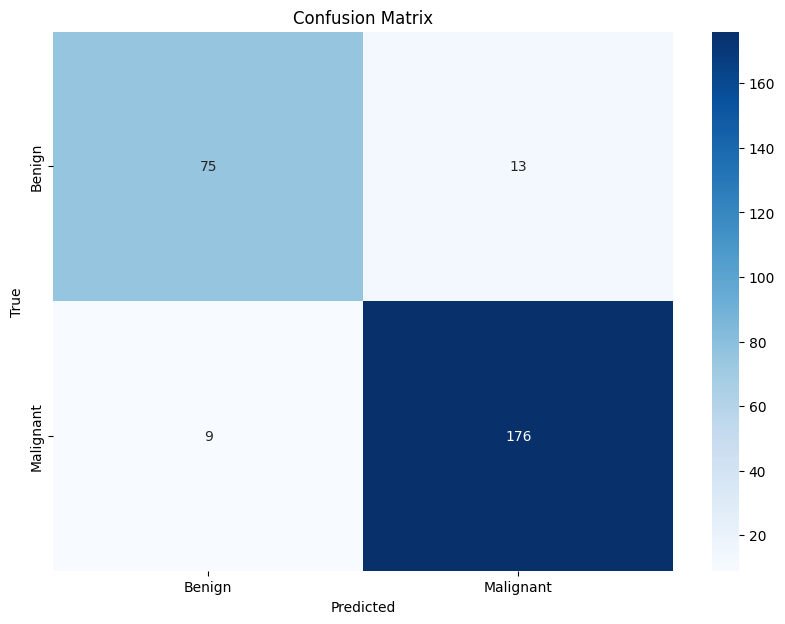

Plotted confusion matrix.
Evaluation complete. Returning results.


{'accuracy': 0.9194139194139194,
 'classification_report': {'Benign': {'precision': 0.8928571428571429,
   'recall': 0.8522727272727273,
   'f1-score': 0.872093023255814,
   'support': 88.0},
  'Malignant': {'precision': 0.9312169312169312,
   'recall': 0.9513513513513514,
   'f1-score': 0.9411764705882353,
   'support': 185.0},
  'accuracy': 0.9194139194139194,
  'macro avg': {'precision': 0.912037037037037,
   'recall': 0.9018120393120393,
   'f1-score': 0.9066347469220246,
   'support': 273.0},
  'weighted avg': {'precision': 0.9188518712328236,
   'recall': 0.9194139194139194,
   'f1-score': 0.9189078135726563,
   'support': 273.0}},
 'confusion_matrix': array([[ 75,  13],
        [  9, 176]], dtype=int64)}

In [11]:
evaluate_model(model, classification_type='binary', desired_magnification='400X')

### **Multiclass Classification Models Fine-Tuning**

#### **Traditional**

#### **Pre-Trained**

**VGG 16**

In [ ]:
def multiclass_classification_vgg16_model(input_shape):
    
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # train some layers and freeze others
    for layer in base_model.layers[:-7]:
        layer.trainable = False
    for layer in base_model.layers[-7:]:
        layer.trainable = True

    model = Sequential()
    
    model.add(base_model)
    
    model.add(Flatten())
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(8, activation='softmax'))
    
    # low learning rate for fine tuning
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
train_gen, val_gen, test_gen, class_weights = preproc_pipeline(desired_magnification='200X', 
                                                    image_resolution=(224, 224), 
                                                    classification_type='multiclass',
                                                    use_data_augmentation=True,
                                                    augmented_images_per_image=6)

vgg16 = multiclass_classification_vgg16_model((224, 224, 3))

fitted_vgg16 = train_model(train_gen, val_gen, vgg16, class_weights=class_weights, epochs=30, early_stopping_patience=5)